In [1]:
from utils_3 import *
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import math
plt.rcParams["figure.figsize"] = (7, 4)

In [34]:
def update_params_with_gd(params, grads, learning_rate):
    L = len(params) // 2
    for i in range(L):
        params["W"+str(i+1)] = params["W"+str(i+1)] - learning_rate * grads["dW"+str(i+1)]
        params["b"+str(i+1)] = params["b"+str(i+1)] - learning_rate * grads["db"+str(i+1)]        
    return params

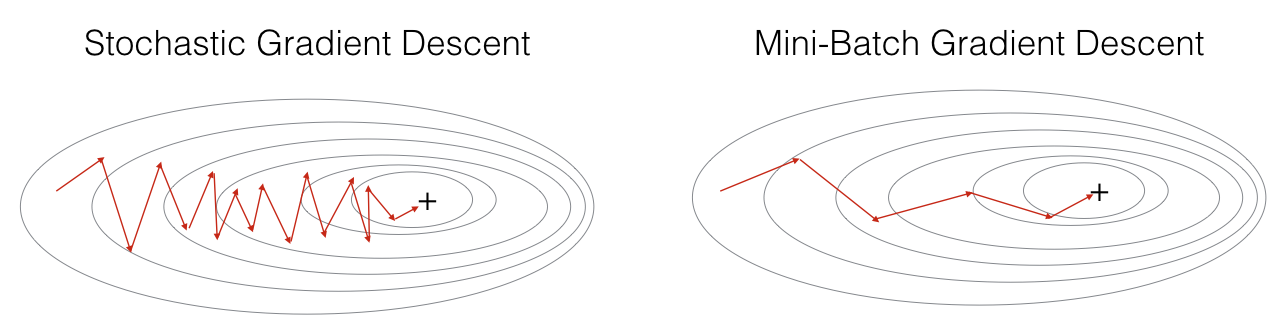

In [35]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed) # to make minibatches the same as number of training examples
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]        
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [36]:
def init_velocity(params):
    L = len(params) // 2
    v = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((params["W"+str(l+1)].shape[:2]))
        v["db" + str(l+1)] = np.zeros((params["b"+str(l+1)].shape[:2]))
    return v

In [53]:
def update_params_with_momentum(params, grads, v, beta, learning_rate):
    L = len(params) // 2
    
    for l in range(L):
        v["dW"+str(l+1)] = beta*v["dW"+str(l+1)] + (1 - beta)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta*v["db"+str(l+1)] + (1 - beta)*grads["db"+str(l+1)]

        params["W"+str(l+1)] = params["W"+str(l+1)] - learning_rate * v["dW"+str(l+1)]
        params["b"+str(l+1)] = params["b"+str(l+1)] - learning_rate * v["db"+str(l+1)]
    return params, v

In [56]:
def init_adam(params):
    L = len(params) // 2
    v, s = {}, {}
    
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros((params["W"+str(l+1)].shape[:2]))
        v["db"+str(l+1)] = np.zeros((params["b"+str(l+1)].shape[:2]))
        s["dW"+str(l+1)] = np.zeros((params["W"+str(l+1)].shape[:2]))
        s["db"+str(l+1)] = np.zeros((params["b"+str(l+1)].shape[:2]))
    return v, s

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$

In [67]:
def update_params_with_adam(params, grads, v, s, t, learning_rate=0.01,
                           beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(params) // 2
    v_corrected, s_corrected = {}, {}
    
    for l in range(L):
        v["dW"+str(l+1)] = beta1 * v["dW"+str(l+1)] + (1 - beta2)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta1 * v["db"+str(l+1)] + (1 - beta2)*grads["db"+str(l+1)]  
        
        v_corrected["dW"+str(l+1)] = v["dW"+str(l+1)] / (1 - beta1**t)
        v_corrected["db"+str(l+1)] = v["db"+str(l+1)] / (1 - beta1**t)
        
        s["dW"+str(l+1)] = beta2*s["dW"+str(l+1)] + (1 - beta2) * (grads["dW"+str(l+1)])**2
        s["db"+str(l+1)] = beta2*s["db"+str(l+1)] + (1 - beta2) * (grads["db"+str(l+1)])**2
        
        s_corrected["dW"+str(l+1)] = s["dW"+str(l+1)] / (1 - beta2**t)
        s_corrected["db"+str(l+1)] = s["db"+str(l+1)] / (1 - beta2**t)
        
        params["W"+str(l+1)] = params["W"+str(l+1)] - learning_rate * v_corrected["dW"+str(l+1)] / (np.square(s_corrected["dW"+str(l+1)]) + epsilon)
        params["b"+str(l+1)] = params["b"+str(l+1)] - learning_rate * v_corrected["db"+str(l+1)] / (np.square(s_corrected["db"+str(l+1)]) + epsilon)
    
    return params, v, s

In [40]:
def load_dataset():
    np.random.seed(3)
    X_train, Y_train = sklearn.datasets.make_moons(n_samples=300, noise=.2)
    plt.scatter(X_train[:, 0],X_train[:, 1], c=Y_train, s=40, cmap=plt.cm.Spectral)
    X_train = X_train.T
    Y_train = Y_train.reshape((1, Y_train.shape[0]))
    
    return X_train, Y_train

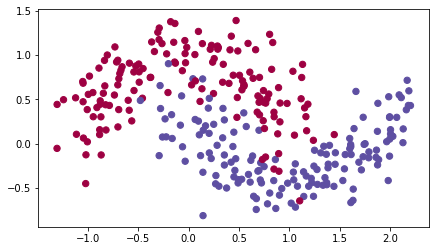

In [41]:
X_train, Y_train = load_dataset()

In [50]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64,
         beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10_000, print_cost=True):
    L = len(layers_dims)
    costs = []
    t = 0
    m = X.shape[1]
    seed = 10
    
    params = init_params(layers_dims)
    
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = init_velocity(params)
    elif optimizer == "adam":
        v, s = init_adam(params)
        
    for i in range(num_epochs):
        seed += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            
            a3, caches = forward_propagation(minibatch_X, params)
            
            cost_total += compute_cost(a3, minibatch_Y)
            
            grads = backprop(minibatch_X, minibatch_Y, caches)
            
            if optimizer == "gd":
                params = update_params_with_gd(params, grads, learning_rate)
            elif optimizer == "momentum":
                params, v = update_params_with_momentum(params, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t += 1
                params, v, s = update_params_with_adam(params, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
                
        cost_avg = cost_total / m
        
        if print_cost and i % 1000 == 0:
            print("Cost after epoch {}: {}".format(i, cost_avg))
        if i % 100 == 0:
            costs.append(cost_avg)
    
    plt.plot(costs)
    plt.ylabel("cost")
    plt.title("Learning rate = {}".format(learning_rate))
    plt.show()
    
    return params

## Mini-batch Gradient descent

Cost after epoch 0: 0.009306547366690543
Cost after epoch 1000: 0.007491235784817149
Cost after epoch 2000: 0.006822625505982396
Cost after epoch 3000: 0.006321332121386108
Cost after epoch 4000: 0.006112374491096328
Cost after epoch 5000: 0.005932780129916283
Cost after epoch 6000: 0.005804702160161345
Cost after epoch 7000: 0.005606098901298467
Cost after epoch 8000: 0.005665958987809063
Cost after epoch 9000: 0.0056901137521111166


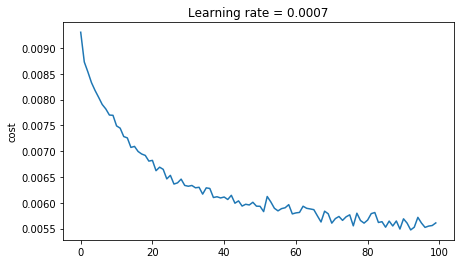

Accuracy: 0.8633333333333333


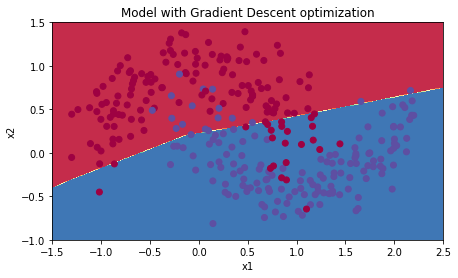

In [51]:
from utils import plot_decision_boundary

layers_dims = [X_train.shape[0], 5, 2, 1]
params = model(X_train, Y_train, layers_dims, optimizer="gd")

preds = predict(X_train, Y_train, params)

plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(params, x.T), X_train, Y_train)

## Mini-batch Gradient Descent with Momentum

Cost after epoch 0: 0.011609378439334123
Cost after epoch 1000: 0.007457153481825638
Cost after epoch 2000: 0.006257172896276925
Cost after epoch 3000: 0.005865675004233461
Cost after epoch 4000: 0.005687774053579072
Cost after epoch 5000: 0.005483012959164885
Cost after epoch 6000: 0.005420537300635946
Cost after epoch 7000: 0.005252092587661872
Cost after epoch 8000: 0.005339135619931011
Cost after epoch 9000: 0.005420093682333024


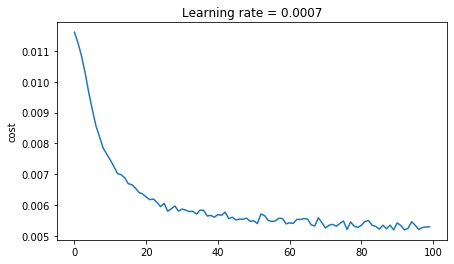

Accuracy: 0.8666666666666667


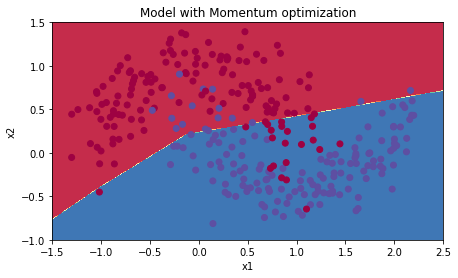

In [54]:
layers_dims = [X_train.shape[0], 5, 2, 1]
params = model(X_train, Y_train, layers_dims, beta=0.9, optimizer="momentum")

preds = predict(X_train, Y_train, params)

plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(params, x.T), X_train, Y_train)

## Mini-batch with Adam mode

R:\PYTHON\MLProjects\Scratch\utils_3.py:46: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)
R:\PYTHON\MLProjects\Scratch\utils_3.py:46: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)


Cost after epoch 0: 0.010440263793331179
Cost after epoch 1000: 0.009725329247302482
Cost after epoch 2000: 0.009823059732422795
Cost after epoch 3000: 0.009737041363783465
Cost after epoch 4000: 0.009836804223046124
Cost after epoch 5000: 0.009829594025688495
Cost after epoch 6000: 0.009788028171852143
Cost after epoch 7000: 0.009819719004638662
Cost after epoch 8000: 0.009855038951930555
Cost after epoch 9000: 0.00981868568357257


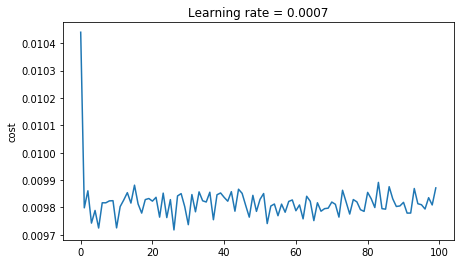

Accuracy: 0.6433333333333333


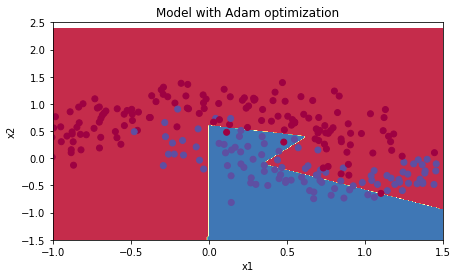

In [69]:
layers_dims = [X_train.shape[0], 5, 2, 1]
params = model(X_train, Y_train, layers_dims, optimizer="adam")

preds = predict(X_train, Y_train, params)
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_ylim([-1.5, 2.5])
axes.set_xlim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(params, x.T), X_train, Y_train)